In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *

simplefilter(action='ignore', category=FutureWarning)

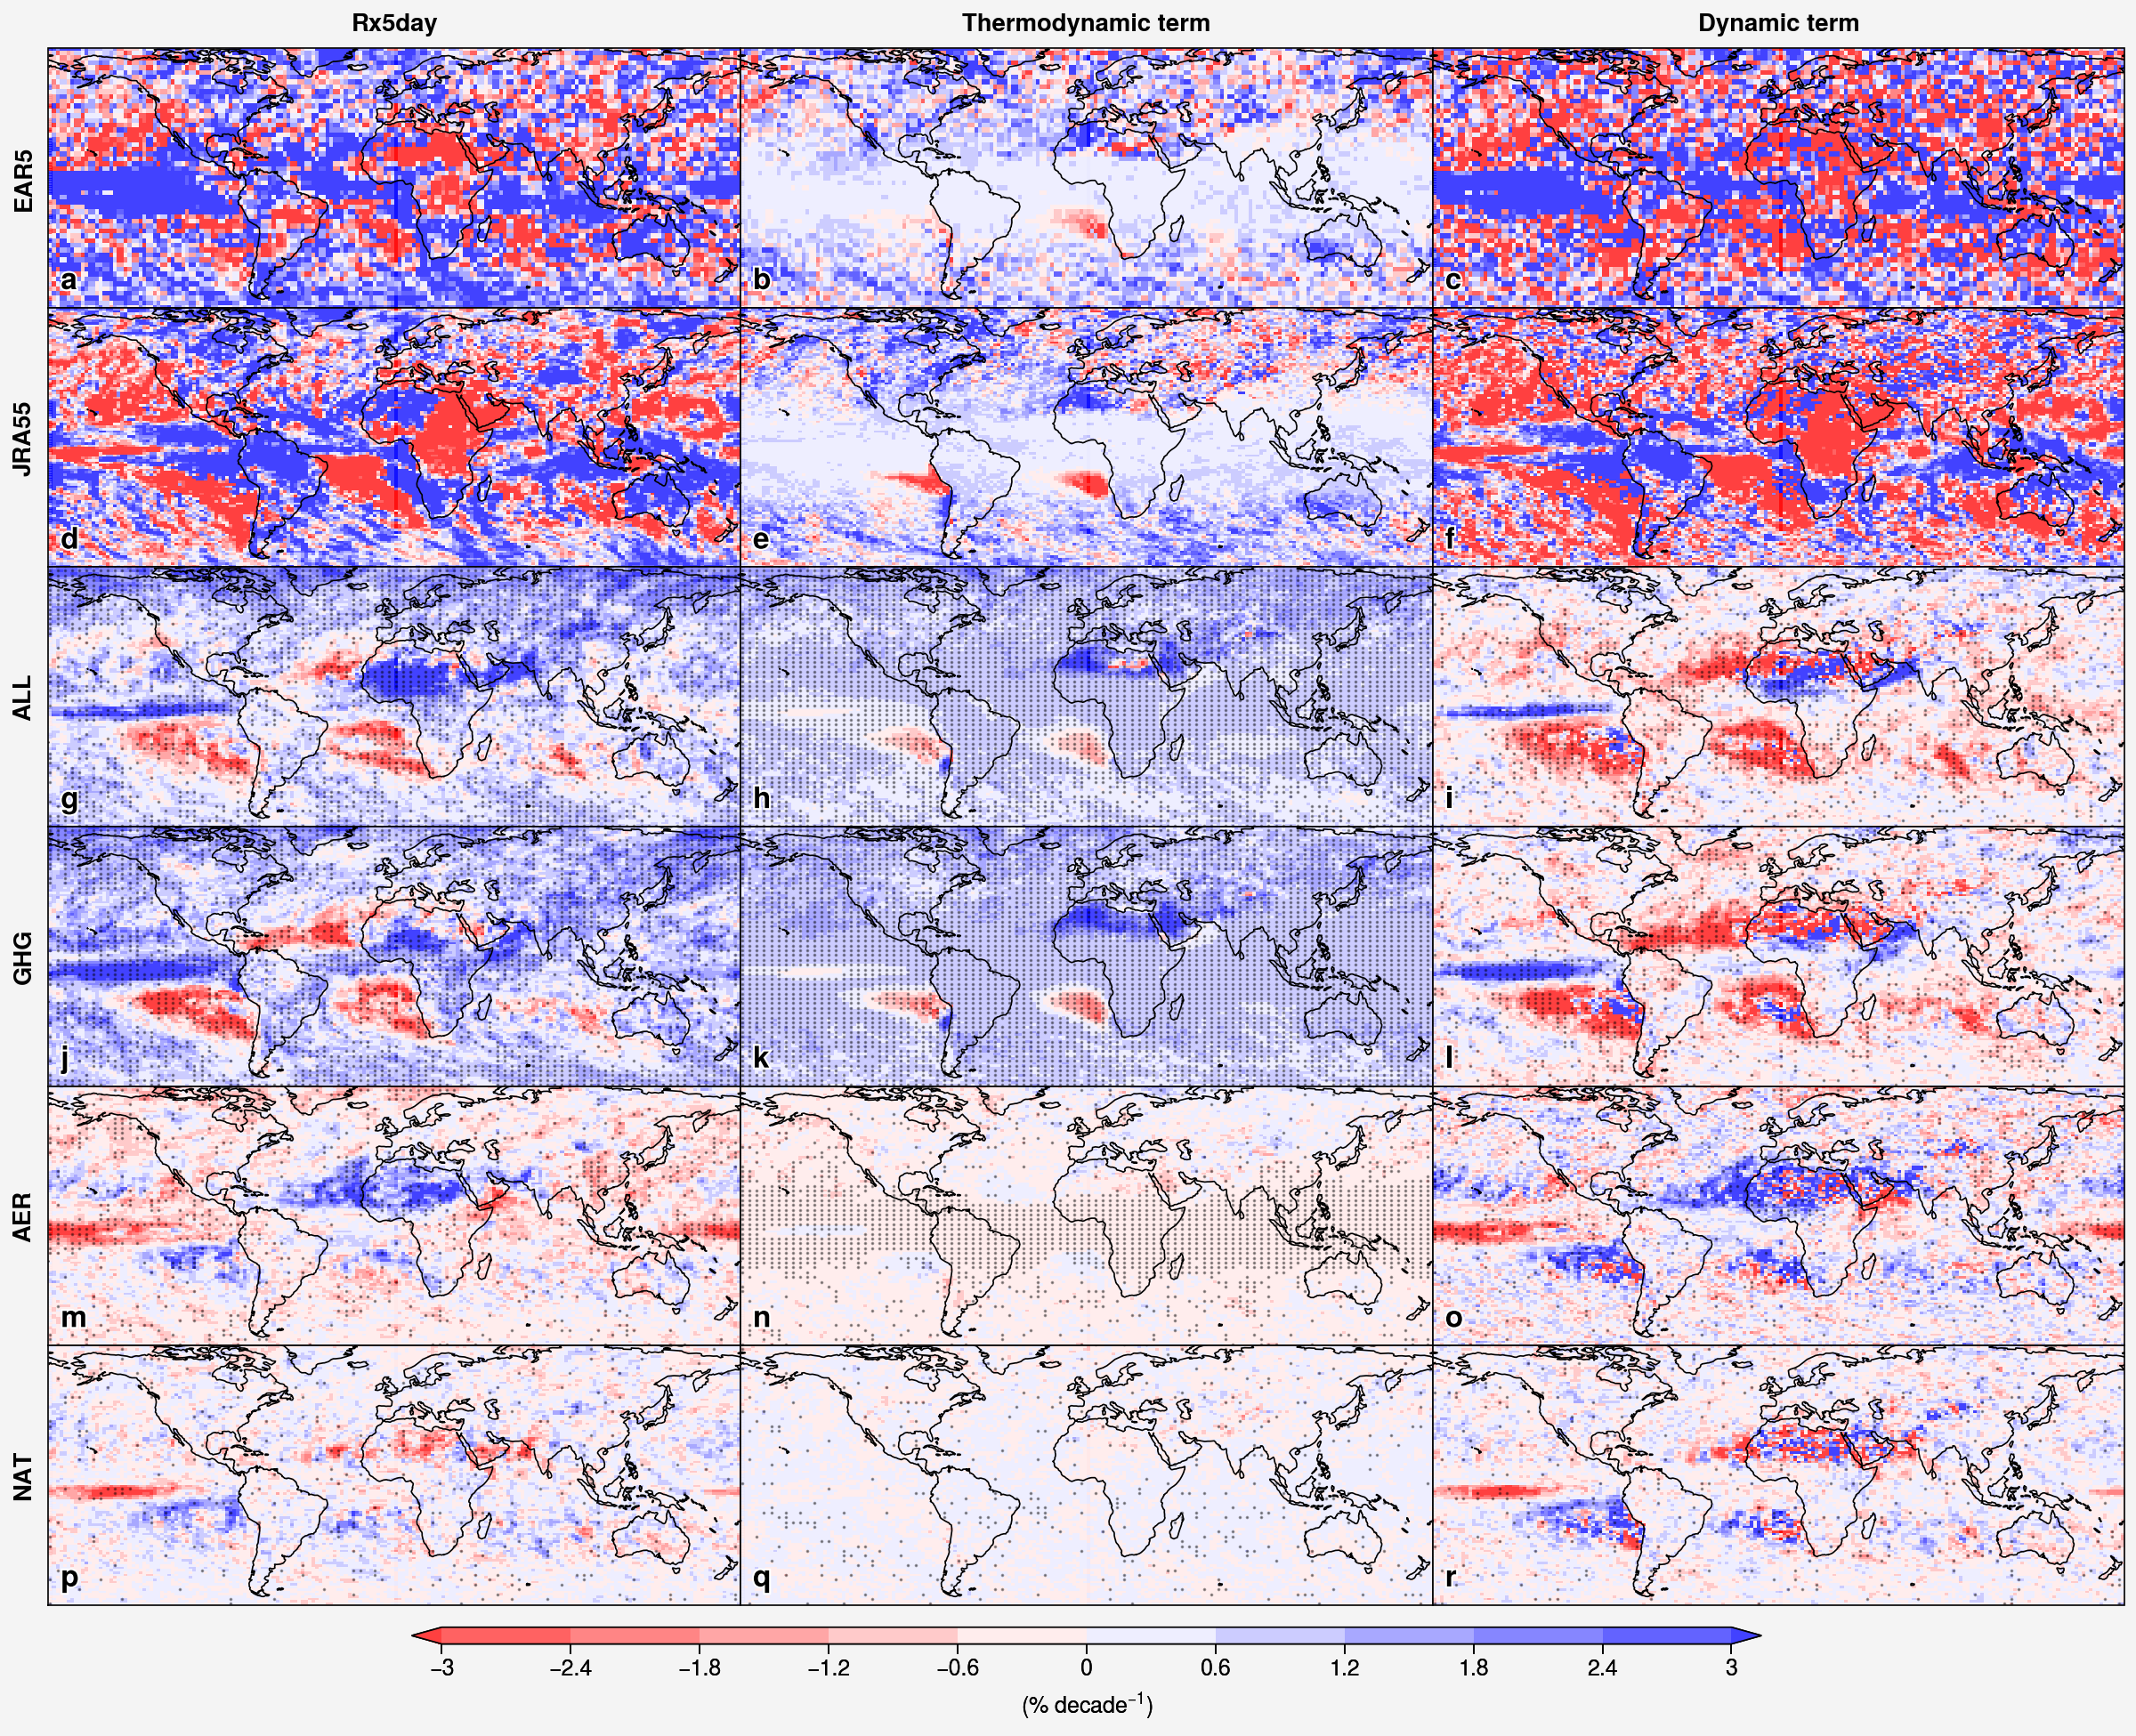

In [4]:
fig, axs = pplot.subplots(ncols=3,nrows=6,wratios=(1,1,1),wspace=0,hspace=0,share=False,
                        proj='pcarree',width=12)
axs.format(grid=False)
axs.format(abc=True,abcsize=12,abcloc='ll')

vmax=3.
vmin=-3.
levels=11

forcing_list = ['era5','jra55','historical','hist-GHG','hist-aer','hist-nat']
name_list    = ['prec','scaling_thermo','scaling_dynamic',]

ax_locs  = {
            'era5':{'prec':0,'scaling_thermo':1,'scaling_dynamic':2},
            'jra55':{'prec':3,'scaling_thermo':4,'scaling_dynamic':5},
            'historical':{'prec':6,'scaling_thermo':7,'scaling_dynamic':8},
            'hist-GHG':{'prec':9,'scaling_thermo':10,'scaling_dynamic':11},
            'hist-aer':{'prec':12,'scaling_thermo':13,'scaling_dynamic':14}, 
            'hist-nat':{'prec':15,'scaling_thermo':16,'scaling_dynamic':17},    
            }

model_path   = {'historical':'historical','hist-aer':'aer','hist-GHG':'GHG','hist-nat':'nat'}

for f in forcing_list:
    forcing  = f
    if forcing == 'era5':
        prec_era5 = Rx5dayCond('prec','era5','era5','reanalysis',mask='None')
        prec_era5_mean = prec_era5.multiyear_mean()
        for n in name_list:
            var0 = Rx5dayCond(n,'era5','era5','reanalysis',mask='None')
            if n == 'prec':
                var0_trend = var0.trend_cal() * 10
            else:
                var0_trend = var0.trend_cal() * 10 * 5
            var0_trend = var0_trend / prec_era5_mean * 100
            lon = var0_trend['lon']
            lats1d = var0_trend['lat']
            data1  = var0_trend[var_name[n]]
            data1, lons1d = add_cyclic_point(data1, coord=lon)
            data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2

            ax_loc = ax_locs[f][n]
            axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                                extend = 'both',cmap=cmaps.MPL_bwr_r)
            axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

    elif forcing == 'jra55':
        prec_jra55 = Rx5dayCond('prec','jra55','jra55','reanalysis',mask='None')
        prec_jra55_mean = prec_jra55.multiyear_mean()
        for n in name_list:
            var0 = Rx5dayCond(n,'jra55','jra55','reanalysis',mask='None')
            if n == 'prec':
                var0_trend = var0.trend_cal() * 10
            else:
                var0_trend = var0.trend_cal() * 10 * 5
            var0_trend = var0_trend / prec_jra55_mean * 100
            lon = var0_trend['lon']
            lats1d = var0_trend['lat']
            data1  = var0_trend[var_name[n]]
            data1, lons1d = add_cyclic_point(data1, coord=lon)
            data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2

            ax_loc = ax_locs[f][n]
            axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                                extend = 'both',cmap=cmaps.MPL_bwr_r)
            axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

    else:
        for n in name_list:
            name = n
            ensemble = ensembles[f]
            ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
            ens_num  = len(ensemble)
            mmm_slp  = 0
            acc_sign_up_num = 0
            acc_sign_down_num = 0
            for i in ensemble:
                src_id = i.split('_')[0]
                run    = i.split('_')[2]
                pi_time = i.split('_')[3]

                prec_ens_i  = Rx5dayCond('prec',forcing,src_id,run,mask='None',pi_time=pi_time)
                prec_ens_i_mean = prec_ens_i.multiyear_mean()
                ens_i  = Rx5dayCond(name,forcing,src_id,run,mask='None',pi_time=pi_time)
                
                if n == 'prec':
                    ens_i_slp = ens_i.trend_cal() * 10
                else:
                    ens_i_slp = ens_i.trend_cal() * 10 * 5

                ens_i_slp = ens_i_slp / prec_ens_i_mean * 100

                acc_sign_up_num  = acc_sign_up_num + (ens_i_slp > 0)*1
                acc_sign_down_num  = acc_sign_down_num + (ens_i_slp < 0)*1
                mmm_slp   = mmm_slp + ens_i_slp
            mmm_slp  = mmm_slp / ens_num
            mmm_sig  = ((mmm_slp>0)*(acc_sign_up_num>=ens_num*2/3)) + ((mmm_slp<0)*(acc_sign_down_num>=ens_num*2/3))

            mmm_slp  = mmm_slp[var_name[name]]
            mmm_sig  = mmm_sig[var_name[name]]

            lons = mmm_slp['lon']
            lats1d = mmm_slp['lat']
            data1  = mmm_slp
            data2  = mmm_sig
            data1, lons1d = add_cyclic_point(data1, coord=lon)
            data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2

            ax_loc = ax_locs[f][n]

            p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                                    extend = 'both',cmap=cmaps.MPL_bwr_r)
            
            X,Y = np.meshgrid(lons[::2],lats1d[::2]) 
            sig = data2[::2,::2]
            X = X[sig]
            Y = Y[sig]
            axs[ax_loc].scatter(X,Y,s=0.5,c='black',alpha=0.35)
            axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

axs.format(leftlabels=('EAR5', 'JRA55', 'ALL', 'GHG', 'AER', 'NAT'),toplabels=('Rx5day','Thermodynamic term','Dynamic term'))

fig.colorbar(p,loc='b',width='0.75em',cols=(1,3),title='(% ${decade^{-1}}$)',length=0.65)
fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS14_Rx5day_trends_under_forcings_percentage.pdf')
